<a href="https://colab.research.google.com/github/blt-tsp/ppo-agent/blob/main/lunar_lander_RLagent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install 'ray[rllib]'

In [4]:
!pip install tensorflow

In [5]:
!apt install swig cmake

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [6]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

# Understanding environnement
## Tests and running some sequences from Lunar Lander env

In [ ]:
import gymnasium as gym

# Creating and reset env

env = gym.make("LunarLander-v2")
obs, info = env.reset()

for _ in range(10):

  # Taking random action from the space
  action = env.action_space.sample()
  print("Action :", action)

  # Carry out action in env and getting observations and bool if timeout or crash
  obs, reward, timeout, crashed, info = env.step(action)

  if timeout or crashed :
    print("Reset")
    obs, info = env.reset()

# don't forget to close env
env.close()

Action : 2
Action : 2
Action : 0
Action : 1
Action : 0
Action : 3
Action : 1
Action : 1
Action : 0
Action : 3


In [ ]:
env = gym.make("LunarLander-v2")
env.reset()

print("Observation space shape :", env.observation_space.shape)
print("Sample observation :", env.observation_space.sample()) # Get a random observation

Observation space shape : (8,)
Sample observation : [74.311905   69.35948    -0.20637977  0.83572084  2.883601   -1.0164675
  0.09314613  0.7761887 ]


 - observation vector :
x, y, v_x, v_y, angle, v_angle, ?, ?

In [ ]:
print("Action space shape :", env.action_space.n)
print("Action space sample :", env.action_space.sample()) # Take a random action

Action space shape : 4
Action space sample : 3


- Action 0: Do nothing,
- Action 1: Fire left orientation engine,
- Action 2: Fire the main engine,
- Action 3: Fire right orientation engine.


In [ ]:
env.close()

# Creating the agent

## train.py

In [ ]:
!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827618 sha256=5e2fa4b60df847a13bb421ec64960f39fe735eb69759ec244fafd23adff4cd17
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.2.0
    Uninstalling gym-0.2.0:
      Successfully uninstalled gym-0.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [2]:
import ray
from ray import tune
from ray.rllib.algorithms import ppo
from ray.tune.logger import pretty_print
import gym
import matplotlib.pyplot as plt

ray.shutdown()

def train_ppo(env_name, reward_fn, lr, lbd, clip_param):
  # Define environment and config
  config = {
      "env": env_name,
      "reward_fn": reward_fn,
      "framework": "tf",
      "num_workers": 1,
      "lambda": lbd,
      "clip_param": clip_param,
      "lr": lr,
      "gamma": 0.99,
      "sgd_minibatch_size": 256,
      "train_batch_size": 2000,
      "num_iterations": 100000,
  }

  # Agent training
  results = tune.run(
      "PPO",
      name = "my_experiment",
      config=config,
      stop={"timesteps_total": 100000},
      checkpoint_at_end=True,
      metric="episode_reward_mean",
      mode="max",
  )

  return results

In [ ]:
# Launch training in discrete space, using best hyperparams
ray.init(num_cpus=2, num_gpus=0, ignore_reinit_error=True)
res = train_ppo('LunarLander-v2', lr=3e-4, lbd=0.9, clip_param=0.2)
ray.shutdown()

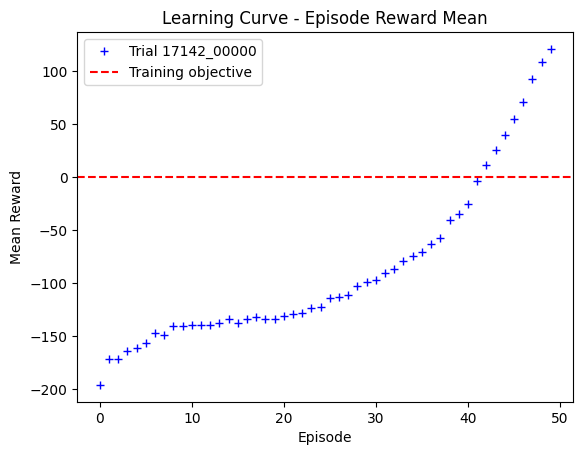

Best Checkpoint for Trial PPO_LunarLander-v2_17142_00000: Checkpoint(filesystem=local, path=/root/ray_results/my_experiment/PPO_LunarLander-v2_17142_00000_0_2024-01-07_10-54-11/checkpoint_000000)


In [ ]:
# Extract results and plot learning curves
%matplotlib inline

def analyze_and_plot(results):
  analysis = tune.ExperimentAnalysis(results.experiment_path)
  dfs = analysis.trial_dataframes
  threshold = 0

  for trial, df in dfs.items():
      episode_rewards_mean = df["episode_reward_mean"]
      plt.plot(episode_rewards_mean, '+', label=f"Trial {trial}", color='b')
      plt.axhline(y=threshold, color='r', linestyle='--', label='Training objective')

  plt.title("Learning Curve - Episode Reward Mean")
  plt.xlabel("Episode")
  plt.ylabel("Mean Reward")
  plt.legend()
  plt.show()
  # Save the best checkpoint for each trial
  for trial in analysis.trials:
      best_checkpoint = analysis.get_best_checkpoint(trial, metric="episode_reward_mean", mode="max")
      print(f"Best Checkpoint for Trial {trial}: {best_checkpoint}");

# Learning curve - reward by episode
analyze_and_plot(res)

ray.shutdown()

In [ ]:
# restore a model from the last checkpoint
trial = res.get_best_trial("episode_reward_mean", "max")
checkpoint = res.get_best_checkpoint(
  trial,
  "training_iteration",
  "max",
)
ray.shutdown()

## Rollout and visualize landing

In [ ]:
# Perform a rollout
from ray.rllib.algorithms import Algorithm
import ray
import gym
import matplotlib.pyplot as plt
import tensorflow as tf

ray.shutdown()

def rollout_display(env_name, checkpoint):

  ray.init(num_cpus=2, ignore_reinit_error=True)
  checkpoint_path = checkpoint.to_directory()
  config = {
      "env": env_name,
      "framework": "tf",
      "num_workers": 1,
      "lambda": 0.95,
      "clip_param": 0.1,
      "lr": 5e-4,
      "gamma": 0.99,
      "sgd_minibatch_size": 256,
      "train_batch_size": 2000,
      "num_iterations": 100000,
  }

  results = tune.run(
      "PPO",
      config=config,
      restore=checkpoint_path,
      stop={"timesteps_total": 100000},
      num_samples=1,
  )

  agent = Algorithm.from_checkpoint(results.get_last_checkpoint())
  return agent

AttributeError: module 'gym' has no attribute 'spaces'

In [ ]:
# Generating agent
agent = rollout_display('LunarLander-v2', checkpoint)
ray.shutdown()

In [ ]:
import gym
from gym.wrappers import Monitor              # Need to downgrade gym, deprecated
from IPython.display import HTML

def record_video(env_name, agent, video_name='landing_video'):
    env = gym.make(env_name, render_mode='rgb_array')

    # Wrap the environment with the Monitor to record the video
    env = Monitor(env, video_name, force=True, video_callable=lambda episode: True)

    observation = env.reset()
    done = False

    while not done:
        frame = env.render(mode='rgb_array')
        action = agent.compute_single_action(observation)
        observation, reward, done, _ = env.step(action)

    env.close()

    # Display the recorded video
    html = env.get_video_html()
    HTML(html)

# Generating video of landing using trained agent
record_video(env_name='LunarLander-v2', agent=agent)

ImportError: cannot import name 'Monitor' from 'gym.wrappers' (/usr/local/lib/python3.10/dist-packages/gym/wrappers/__init__.py)

# Hyperparameters tuning

In [ ]:
import ray
from ray import tune
from ray.tune import CLIReporter
import os
import gym

def train(config):
    env_name = "LunarLander-v2"
    config["env"] = env_name

    stop_iteration = config.get("stop_iteration", 100)  # Set a maximum number of training iterations
    for i in range(stop_iteration):
        result = config.training_iteration()
        mean_reward = result["episode_reward_mean"]

        # Use ray.train.report() to report results
        tune.report(mean_reward=mean_reward, training_iteration=i+1)

        # Stopping criteria: Stop when mean_reward reaches 200
        if mean_reward >= 0:
            break

config_space = {
    "lambda": tune.grid_search([0.8, 0.9, 0.95]),
    "clip_param": tune.grid_search([0.1, 0.2, 0.3]),
    "lr": tune.grid_search([1e-4, 3e-4, 1e-3]),
    "stop_iteration": 100,  # Number of training iterations
}

reporter = CLIReporter(metric_columns=["mean_reward", "training_iteration"])

ray.init(num_cpus=2, num_gpus=1, ignore_reinit_error=True)

# Use an absolute path for local_dir
absolute_path = os.path.abspath("./tune_results")

analysis = tune.run(
    train,
    config=config_space,
    num_samples=3,
    local_dir=absolute_path,
    progress_reporter=reporter,
)


# Get best hyperparameters
best_config = analysis.get_best_config(metric="mean_reward", mode="max")
print("Best Hyperparameters:", best_config)

ray.shutdown()


2024-01-07 11:08:07,162	INFO worker.py:1558 -- Calling ray.init() again after it has already been called.
2024-01-07 11:08:07,170	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-07 11:08:07,195	WARNING tune.py:916 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+--------------------------------------------------------------+
| Configuration for experiment     train_2024-01-07_11-08-07   |
+--------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator       |
| Scheduler                        FIFOScheduler               |
| Number of trials                 81                          |
+--------------------------------------------------------------+

View detailed results here: /content/tune_results/train_2024-01-07_11-08-07
To visualize your results with TensorBoard, run: `tensorboard --logdir /content/tune_results/train_2024-01-07_11-08-07`

Trial status: 16 PENDING
Current time: 2024-01-07 11:08:07. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+-----------------------------------------------------------------+
| Trial name          status       lambda     clip_param       lr |
+-----------------------------------------------------------------+
| train_091b2_000

2024-01-07 11:08:13,531	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28148, ip=172.28.0.12, actor_id=bc18b9e1f0c7e38541e7125601000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00000 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00000 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                0.8 |
| lr                                 0.0001 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00000 errored after 0 iterations at 2024-01-07 11:08:13. Total running time: 6s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00000_0_clip_param=0.1000,lambda=0.8000,lr=0.0001_2024-01-07_11-08-07/error.txt

Trial train_091b2_00001 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00001 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                0.8 |
| lr                                 0.0001 |

2024-01-07 11:08:19,509	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28283, ip=172.28.0.12, actor_id=26d74e33c46e201a7e30c97101000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00002 errored after 0 iterations at 2024-01-07 11:08:19. Total running time: 12s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00002_2_clip_param=0.3000,lambda=0.8000,lr=0.0001_2024-01-07_11-08-07/error.txt

Trial train_091b2_00003 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00003 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                0.9 |
| lr                                 0.0001 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00003 errored after 0 iterations at 2024-01-07 11:08:19. Total running time: 12s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00003_3_clip_param=0.1000,lambda=0.9000,lr=0.0001_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:24,515	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28409, ip=172.28.0.12, actor_id=dd5ca22983059323be1c1cbc01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00004 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00004 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                0.9 |
| lr                                 0.0001 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00004 errored after 0 iterations at 2024-01-07 11:08:24. Total running time: 17s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00004_4_clip_param=0.2000,lambda=0.9000,lr=0.0001_2024-01-07_11-08-07/error.txt

Trial train_091b2_00005 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00005 config            |
+-------------------------------------------+
| clip_param                            0.3 |
| lambda                                0.9 |
| lr                                 0.0001 

2024-01-07 11:08:32,215	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28540, ip=172.28.0.12, actor_id=0eb72cf35cc456401cfcb66c01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00006 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00006 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                  1 |
| lr                                 0.0001 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00006 errored after 0 iterations at 2024-01-07 11:08:32. Total running time: 25s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00006_6_clip_param=0.1000,lambda=1.0000,lr=0.0001_2024-01-07_11-08-07/error.txt

Trial train_091b2_00007 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00007 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                  1 |
| lr                                 0.0001 

2024-01-07 11:08:36,704	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28647, ip=172.28.0.12, actor_id=5666aad0eecb2f580a9167a301000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00008 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00008 config            |
+-------------------------------------------+
| clip_param                            0.3 |
| lambda                                  1 |
| lr                                 0.0001 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00008 errored after 0 iterations at 2024-01-07 11:08:36. Total running time: 29s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00008_8_clip_param=0.3000,lambda=1.0000,lr=0.0001_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:37,480	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00009
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28676, ip=172.28.0.12, actor_id=22c91010d9228a16d301fcc201000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00009 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00009 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                0.8 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00009 errored after 0 iterations at 2024-01-07 11:08:37. Total running time: 30s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00009_9_clip_param=0.1000,lambda=0.8000,lr=0.0003_2024-01-07_11-08-07/error.txt

Trial status: 10 ERROR | 16 PENDING
Current time: 2024-01-07 11:08:37. Total running time: 30s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+-----------------------------------------------------------------+
| Trial name          status       lambda     clip_param       lr |
+---------------------------------------------------

2024-01-07 11:08:41,966	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00010
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28773, ip=172.28.0.12, actor_id=1caaf26a6833f7dfb2f083bd01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00010 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00010 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                0.8 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00010 errored after 0 iterations at 2024-01-07 11:08:41. Total running time: 34s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00010_10_clip_param=0.2000,lambda=0.8000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:46,127	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00011
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28802, ip=172.28.0.12, actor_id=d811655d7bde491f62f3e99401000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00011 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00011 config            |
+-------------------------------------------+
| clip_param                            0.3 |
| lambda                                0.8 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00011 errored after 0 iterations at 2024-01-07 11:08:46. Total running time: 38s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00011_11_clip_param=0.3000,lambda=0.8000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:47,692	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00012
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28898, ip=172.28.0.12, actor_id=2a79daadf7869ca512cf751501000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00012 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00012 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                0.9 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00012 errored after 0 iterations at 2024-01-07 11:08:47. Total running time: 40s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00012_12_clip_param=0.1000,lambda=0.9000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:51,497	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00013
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=28973, ip=172.28.0.12, actor_id=90347ea0669409b9c4e1baf101000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00013 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00013 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                0.9 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00013 errored after 0 iterations at 2024-01-07 11:08:51. Total running time: 44s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00013_13_clip_param=0.2000,lambda=0.9000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:53,091	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00014
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=29029, ip=172.28.0.12, actor_id=f384f0dce89aec50bc98859d01000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00014 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00014 config            |
+-------------------------------------------+
| clip_param                            0.3 |
| lambda                                0.9 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00014 errored after 0 iterations at 2024-01-07 11:08:53. Total running time: 45s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00014_14_clip_param=0.3000,lambda=0.9000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:56,390	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00015
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=29098, ip=172.28.0.12, actor_id=d21499668ad7b5877926ced001000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00015 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00015 config            |
+-------------------------------------------+
| clip_param                            0.1 |
| lambda                                  1 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00015 errored after 0 iterations at 2024-01-07 11:08:56. Total running time: 49s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00015_15_clip_param=0.1000,lambda=1.0000,lr=0.0003_2024-01-07_11-08-07/error.txt


2024-01-07 11:08:58,088	ERROR tune_controller.py:1374 -- Trial task failed for trial train_091b2_00016
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(AttributeError): ray::ImplicitFunc.train() (pid=29103, ip=172.28.0.12, actor_id=fff4e46abfa33bb03160c4c401000000, repr=train)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 342, in train
    raise skipped from exception_cause(skipped)


Trial train_091b2_00016 started with configuration:
+-------------------------------------------+
| Trial train_091b2_00016 config            |
+-------------------------------------------+
| clip_param                            0.2 |
| lambda                                  1 |
| lr                                 0.0003 |
| stop_iteration                         10 |
+-------------------------------------------+

Trial train_091b2_00016 errored after 0 iterations at 2024-01-07 11:08:58. Total running time: 50s
Error file: /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00016_16_clip_param=0.2000,lambda=1.0000,lr=0.0003_2024-01-07_11-08-13/error.txt


2024-01-07 11:09:01,000	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 



Trial status: 17 ERROR | 16 PENDING
Current time: 2024-01-07 11:09:01. Total running time: 53s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs
+-----------------------------------------------------------------+
| Trial name          status       lambda     clip_param       lr |
+-----------------------------------------------------------------+
| train_091b2_00017   PENDING         1              0.3   0.0003 |
| train_091b2_00018   PENDING         0.8            0.1   0.001  |
| train_091b2_00019   PENDING         0.8            0.2   0.001  |
| train_091b2_00020   PENDING         0.8            0.3   0.001  |
| train_091b2_00021   PENDING         0.9            0.1   0.001  |
| train_091b2_00022   PENDING         0.9            0.2   0.001  |
| train_091b2_00023   PENDING         0.9            0.3   0.001  |
| train_091b2_00024   PENDING         1              0.1   0.001  |
| train_091b2_00025   PENDING         1              0.2   0.001  |
| train_091b2_00026   PENDING         1    

2024-01-07 11:09:03,712	ERROR tune.py:1038 -- Trials did not complete: [train_091b2_00000, train_091b2_00001, train_091b2_00002, train_091b2_00003, train_091b2_00004, train_091b2_00005, train_091b2_00006, train_091b2_00007, train_091b2_00008, train_091b2_00009, train_091b2_00010, train_091b2_00011, train_091b2_00012, train_091b2_00013, train_091b2_00014, train_091b2_00015, train_091b2_00016]
2024-01-07 11:09:03,724	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-01-07 11:09:03,750	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 16 trial(s):
- train_091b2_00017: FileNotFoundError('Could not fetch metrics for train_091b2_00017: both result.json and progress.csv were not found at /content/tune_results/train_2024-01-07_11-08-07/train_091b2_00017_17_clip_param=0.3000,lambda=1.0000,lr=0.0003_2024-01-07_11-08-13')
- train_091b2_00018: FileNotFoundError('Could not fetch metri


Best Hyperparameters: None


# Adding less fuel consumption objective

Here is a modified reward function adding penalties for using to much fuel. How the model will react to changes ?

In [7]:
import numpy as np

def basic_reward(state, action, next_state):
    # Reward for descending gently
    descent_reward = 1.0 - abs(next_state[1])

    # Reward for aligning with the landing pad
    alignment_reward = 1.0 - abs(next_state[4])

    # Penalty for fuel usage (negative reward)
    fuel_penalty = -0.1 * np.linalg.norm(action)

    # Combine the reward components
    total_reward = descent_reward + alignment_reward + fuel_penalty

    return total_reward


In [1]:
import gym
import ray
from ray import tune

# Define a custom reward function with adjusted shaping
def complex_reward(state, action, next_state, reward, done):
    # Extract relevant information from the state
    position_x = state[0]
    position_y = state[1]
    velocity_x = state[2]
    velocity_y = state[3]
    angle = state[4]
    angular_velocity = state[5]
    left_leg_contact = state[6]
    right_leg_contact = state[7]

    # Penalize for using engine thrust (negative reward)
    fuel_penalty = -0.1 * abs(action[0])

    # Reward for moving towards the landing pad
    landing_reward = 10.0 * (position_x + 0.5)

    # Additional rewards for a safe landing and less fuel consumption
    if abs(position_x) < 0.05 and abs(position_y) < 0.05 and velocity_y <= 0.0:
        landing_reward += 100.0
        fuel_penalty -= 0.1  # Encourage less fuel consumption during safe landing

    # Combine rewards
    total_reward = reward + fuel_penalty + landing_reward

    return total_reward

In [ ]:
# Launch training in discrete space, using best hyperparams and custom reward
ray.shutdown()
ray.init(num_cpus=2, num_gpus=1, ignore_reinit_error=True)
res = train_ppo('LunarLander-v2', reward_fn=basic_reward, lr=5e-5, lbd=0.9, clip_param=0.1)
ray.shutdown()

2024-01-07 11:58:12,172	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-07 11:58:13,782	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+--------------------------------------------------------+
| Configuration for experiment     my_experiment         |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 1                     |
+--------------------------------------------------------+

View detailed results here: /root/ray_results/my_experiment
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/my_experiment`

Trial status: 1 PENDING
Current time: 2024-01-07 11:58:14. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+-------------------------------------------+
| Trial name                       status   |
+-------------------------------------------+
| PPO_LunarLander-v2_0934b_00000   PENDING  |
+-------------------------------------------+

Trial PPO_LunarLander-v2_0934b_00000 started with configuration:


(PPO pid=44082) Trainable.setup took 11.791 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(PPO pid=44082) Install gputil for GPU system monitoring.
(PPO pid=44082) 2024-01-07 11:58:38,223	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!



Trial PPO_LunarLander-v2_0934b_00000 finished iteration 1 at 2024-01-07 11:58:39. Total running time: 25s
+----------------------------------------------------------+
| Trial PPO_LunarLander-v2_0934b_00000 result              |
+----------------------------------------------------------+
| episodes_total                                        11 |
| num_env_steps_sampled                               1000 |
| num_env_steps_trained                               1000 |
| sampler_results/episode_len_mean                      83 |
| sampler_results/episode_reward_mean             -127.936 |
+----------------------------------------------------------+

Trial PPO_LunarLander-v2_0934b_00000 finished iteration 2 at 2024-01-07 11:58:41. Total running time: 27s
+----------------------------------------------------------+
| Trial PPO_LunarLander-v2_0934b_00000 result              |
+----------------------------------------------------------+
| episodes_total                                      

2024-01-07 12:00:15,539	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Trial status: 1 RUNNING
Current time: 2024-01-07 12:00:15. Total running time: 2min 1s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs
Current best trial: 0934b_00000 with episode_reward_mean=-166.18778892042405 and params={'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'num_learner_workers': 0, 'num_gpus_per_learner_worker': 0, 'num_cpus_per_learner_worker': 1, 'local_gpu_idx': 0, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': True, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'torch_compile_learner': False, 'torch_compile_learner_what_to_comp

2024-01-07 12:00:16,517	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


In [ ]:
analyze_and_plot(res)

# Continuous env

In [2]:
# We just change env
import ray
env="LunarLanderContinuous-v2"
ray.shutdown()
ray.init(num_cpus=2, num_gpus=1, ignore_reinit_error=True)
continuous_res = train_ppo(env_name=env, reward_fn=complex_reward, lr=1e-4, lbd=0.9, clip_param=0.2)
ray.shutdown()

2024-01-07 11:50:37,829	INFO worker.py:1724 -- Started a local Ray instance.


NameError: name 'train_ppo' is not defined

In [ ]:
analyze_and_plot(continuous_res)